# A computational introduction to stochastic differential equations.

Lecture 4.

https://github.com/spdes/computational-sde-intro-lecture.

Solve a Kolmogorov forward equation (a.k.a. Fokker--Planck) using finite difference.

In [1]:
import math
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

np.random.seed(666)

In [2]:
# Geometric Brownian motion SDE.

a, b = -2., 1.


def drift(x):
    return a * x


def dispersion(x):
    return b * x

In [3]:
# Times
dt = 2e-5
T = 10000
ts = np.linspace(dt, dt * T, T)

# Initial condition is a Normal(m0, var0)
m0 = 2.
var0 = 1.

In [4]:
def simulate_true_trajectory(num_trajs: int):
    """We have access to the true solution of the geometric Brownian motion.
    """
    x0s = m0 + math.sqrt(var0) * np.random.randn(num_trajs)
    wss = np.cumsum(math.sqrt(dt) * np.random.randn(num_trajs, T), axis=1)
    return x0s[:, None] * np.exp((a - b ** 2 / 2) * ts + b * wss)

In [5]:
num_trajs = 2000
true_trajectories = simulate_true_trajectory(num_trajs)

Check the histogram at the terminal time.

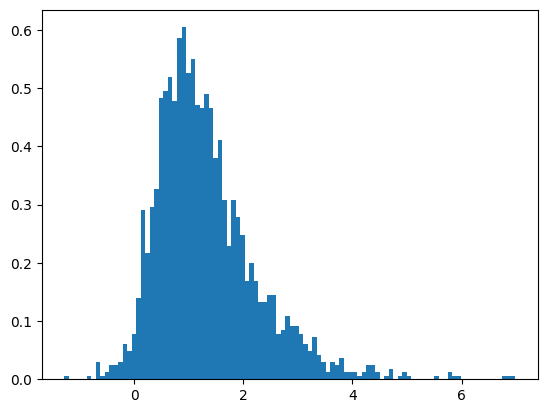

In [6]:
_ = plt.hist(true_trajectories[:, -1], density=True, bins=100)

We solve the Kolmogorov forward equation now using finite difference.

In [7]:
# Uniformly partition the spatial variable on [-2, 6] with 500 points
N = 500
xs = np.linspace(-2, 6, N)
dx = xs[1] - xs[0]

In [8]:
def fpk_operator(ps):
    """Kolmogorov forward equation operator (unidimensional)
    """
    derivative_drift = a
    gamma = dispersion(xs) ** 2
    derivative_gamma = 2 * b ** 2 * xs
    second_derivative_gamma = 2 * b ** 2
    derivative_p = np.gradient(ps, dx)
    second_derivative_p = np.gradient(np.gradient(ps, dx), dx)

    part1 = -(derivative_drift * ps + drift(xs) * derivative_p)
    return part1 + 0.5 * (
                second_derivative_gamma * ps + 2 * derivative_gamma * derivative_p + gamma * second_derivative_p)


def euler(ps):
    r"""Euler's method for solving the ODE.

    p_k \approx p_{k-1} + fpk_operator(p_{k-1}) * dt
    """
    return ps + fpk_operator(ps) * dt


def solve_fpk(p0):
    """Solve the Kolmogorov forward equation.
    """
    pdfs = np.zeros((T, N))
    ps = p0.copy()
    for k in range(T):
        ps = euler(ps)
        pdfs[k, :] = ps
    return pdfs

In [9]:
# Initial condition
p0 = scipy.stats.norm.pdf(xs, m0, np.sqrt(var0))

# Solve
pdfs = solve_fpk(p0)

Check if the solution matches the sample histogram.

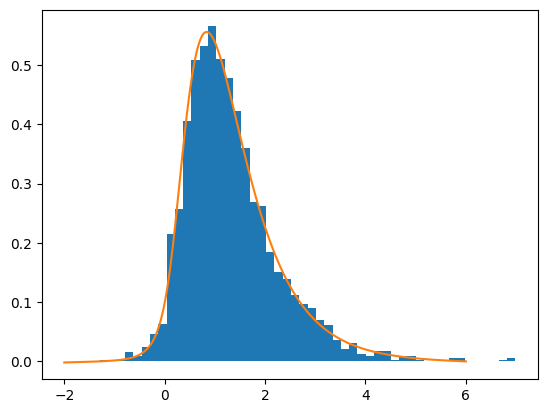

In [10]:
# choose any time k you wish
k = -1
_ = plt.hist(true_trajectories[:, k], density=True, bins=50)
_ = plt.plot(xs, pdfs[k, :])